In [188]:
from sklearn.linear_model import LinearRegression
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib as mpl
import datetime as dt
import pandas as pd
import numpy as np
import os
import topf

%matplotlib inline
mpl.rcParams["axes.labelsize"] = 9
mpl.rcParams["axes.titlesize"] = 9
mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 8
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
ALL_DIR = os.path.join(ROOT_DIR, "data", "All.csv")

In [189]:
# add to df distance to peak
def persistent_filter(data_df, limit):
    filtered_df = data_df.loc[:, data_df.max() > limit].copy()
    topics = [int(column.split("_")[1]) for column in filtered_df.columns]
    for topic in topics:
        topic_arr = filtered_df[f"Topic_{topic}"].to_numpy()
        topic_arr_indexed = np.column_stack((np.arange(topic_arr.shape[0]), topic_arr))
        transformer = topf.PersistenceTransformer()  # prepare transformer
        persistence = transformer.fit_transform(topic_arr_indexed)      # transform data into peaks
        peaks = np.copy(persistence)
        threshold = np.max(topic_arr_indexed[:, 1]) / 2
        peaks[peaks[:, 1] < threshold] = 0
        new_cols = {
            f"peaks_{topic}": peaks[:, 1],
        }
        filtered_df = pd.concat([filtered_df, pd.DataFrame(new_cols, index=filtered_df.index)], axis=1)
        filtered_df = filtered_df.drop(f"Topic_{topic}", axis=1)
    dates_dict = {}
    for topic in topics:
        dates_dict[topic] = []
        for i in range(len(filtered_df[f"peaks_{topic}"])):
            if filtered_df[f"peaks_{topic}"][i] != 0:
                dates_dict[topic].append(str(filtered_df.index[i])[:10]) #filtered_df[f"peaks_{topic}"][i], 
    return filtered_df, topics, dates_dict

In [190]:
data_df = pd.read_csv(os.path.join(ROOT_DIR, "results_10", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
data_df = pd.get_dummies(data_df.filter(["Topic"]), columns=['Topic'])
data_df = data_df.resample("D").sum()

results, topics, dates_dict = persistent_filter(data_df,limit=25)

In [191]:
print(dates_dict)

{0: ['2022-05-12'], 9: ['2022-07-22', '2022-08-01', '2022-10-31'], 12: ['2022-05-09'], 15: ['2022-08-23'], 19: ['2022-04-21', '2022-06-01', '2022-06-15'], 31: ['2022-09-28'], 35: ['2022-06-10', '2022-09-22'], 39: ['2022-01-25', '2022-02-15'], 40: ['2022-04-21', '2022-05-06', '2022-05-17'], 41: ['2022-03-01', '2022-03-04', '2022-03-11'], 44: ['2022-03-02', '2022-03-10'], 49: ['2022-07-28', '2022-08-30', '2022-10-19', '2022-11-11'], 50: ['2022-03-09'], 56: ['2022-04-04'], 61: ['2022-02-26'], 65: ['2022-03-04', '2022-09-01'], 68: ['2022-06-28', '2022-07-15'], 72: ['2022-09-12'], 80: ['2022-02-22'], 81: ['2022-02-28', '2022-09-21', '2022-10-07'], 95: ['2022-03-03'], 97: ['2022-10-10', '2022-10-17'], 103: ['2022-03-07'], 107: ['2022-10-08'], 115: ['2022-02-22', '2022-09-30'], 117: ['2022-09-21'], 122: ['2022-03-28'], 134: ['2022-03-01'], 136: ['2022-08-31'], 149: ['2022-03-11', '2022-04-12'], 159: ['2022-04-15'], 161: ['2022-03-29'], 163: ['2022-03-15'], 164: ['2022-03-08'], 166: ['2022-12-

In [192]:
data_df_date = pd.read_csv(os.path.join(ROOT_DIR, "results_10", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
df_filtered = data_df_date[data_df_date['Topic'].isin(topics)]

In [193]:
import datetime
df = df_filtered.copy()

# create a new column in the dataframe to store the smallest distance in days
df["Smallest_Distance"] = 0
# loop over each row in the dataframe
for index, row in df.iterrows():
    # get the topic for the current article
    topic = row["Topic"]
    # get the comparison dates for the current topic
    comp_dates = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in dates_dict[topic]]
    # get the publishing date for the current article
    date = index.date()
    # compute smallest distance between the publishing date and comparison dates
    distances = [abs((date - comp_date).days) for comp_date in comp_dates]
    smallest_distance = min(distances)
    # update the "Smallest_Distance" column for the current article
    df.loc[index, "Smallest_Distance"] = smallest_distance

#add dummy variable for smallest distance <=3
df["Peak_dummy_3"] = 0
df["Peak_dummy_0"] = 0
df.loc[df["Smallest_Distance"] <= 3, "Peak_dummy_3"] = 1
df.loc[df["Smallest_Distance"] == 0, "Peak_dummy_0"] = 1

#sort df by smallest distance
dfa = df.sort_values(by=['Smallest_Distance'], ascending=True)

#save to csv
dfa.to_csv(os.path.join(ROOT_DIR, "results_10", "All_Results_Dummies.csv"), index=False)

In [130]:
#regress y=resonance, x1=novelty, x2=peak_dummy_0
df["Resonance"] = df["Resonance"].astype(float)
df["Novelty"] = df["Novelty"].astype(float)
df["Peak_dummy_0"] = df["Peak_dummy_0"].astype(float)
df["Topic"] = df["Topic"].astype(float)
df["Smallest_Distance"] = df["Smallest_Distance"].astype(float)

df = df.dropna()

X = df[["Novelty", "Peak_dummy_0"]]
y = df["Resonance"]

reg = LinearRegression().fit(X, y)
#print reg summary with text
print("Resonance = {:.2f} + {:.2f} * Novelty + {:.2f} * Peak_dummy_0".format(reg.intercept_, reg.coef_[0], reg.coef_[1]))
#print r2
print("R2 = {:.2f}".format(reg.score(X, y)))

X = df["Novelty"]
y = df["Resonance"]

reg = LinearRegression().fit(X.values.reshape(-1, 1), y)
#print reg summary with text
print("Resonance = {:.2f} + {:.2f} * Novelty".format(reg.intercept_, reg.coef_[0]))
#print r2
print("R2 = {:.2f}".format(reg.score(X.values.reshape(-1, 1), y)))

#reg resonance peak dummy
X = df["Peak_dummy_0"]
y = df["Resonance"]

reg = LinearRegression().fit(X.values.reshape(-1, 1), y)
#print reg summary with text
print("Resonance = {:.2f} + {:.2f} * Peak_dummy_0".format(reg.intercept_, reg.coef_[0]))
#print r2
print("R2 = {:.2f}".format(reg.score(X.values.reshape(-1, 1), y)))

Resonance = -1.63 + 0.29 * Novelty + 0.04 * Peak_dummy_0
R2 = 0.14
Resonance = -1.62 + 0.29 * Novelty
R2 = 0.14
Resonance = -0.00 + 0.01 * Peak_dummy_0
R2 = 0.00


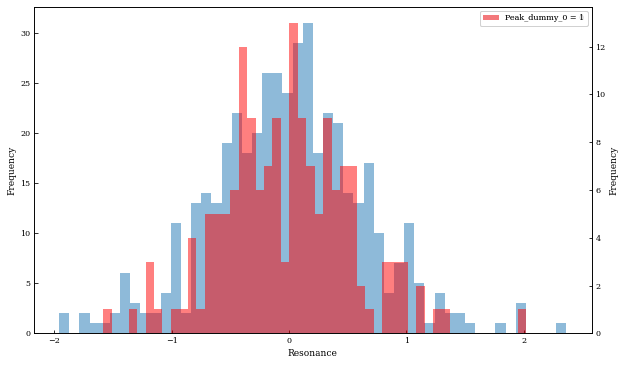

In [202]:
#plot two histograms on the same plot: resonance for peak dummy =0, and resonance for peak dummy =1. alpha 0.5
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.hist(df.loc[df["Peak_dummy_0"] == 0, "Resonance"], bins=50, alpha=0.5, label="Peak_dummy_0 = 0")
# ax.hist(df.loc[df["Peak_dummy_0"] == 1, "Resonance"], bins=50, alpha=0.5, label="Peak_dummy_0 = 1")
# ax.set_xlabel("Resonance")
# ax.set_ylabel("Frequency")
# ax.legend()
# plt.show()

#Same plot as above, but with two y axis
fig, ax1 = plt.subplots(figsize=(10, 6))
#make df, a copy of dfa from dates 2022-02-20 to 2022-02-27

ax1.hist(df.loc[df["Peak_dummy_0"] == 0, "Resonance"], bins=50, alpha=0.5, label="Peak_dummy_0 = 0")
ax1.set_xlabel("Resonance")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2 = ax1.twinx()
ax2.hist(df.loc[df["Peak_dummy_0"] == 1, "Resonance"], color="red",bins=50, alpha=0.5, label="Peak_dummy_0 = 1")
ax2.set_ylabel("Frequency")
ax2.legend()
plt.show()